In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd

from typing import *

In [2]:
from nepal.datasets import NYTimes
from nepal.ml.preprocess import Cases

df: pd.DataFrame = Cases(NYTimes()).preprocessed()

In [4]:
import warnings

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as mape

from nepal.ml.forecaster import BaseForecaster
from nepal.ml.splitter import Splitter


def cross_validate(
    forecaster: BaseForecaster,
    *,
    splitter: Splitter,
    y: pd.DataFrame,
    Xs: Optional[Iterable[pd.DataFrame]] = None,
) -> Sequence[float]:
    scores: List[float] = []
    for df_train, df_test in splitter.train_test_splits(y=y):
        model = forecaster.fit(y=df_train, Xs=Xs)
        df_pred = model.forecast(fh=splitter.fh, y=df_train, Xs=Xs)

        with warnings.catch_warnings():
            warnings.simplefilter(action="ignore", category=FutureWarning)
            score: float = mape(y_true=df_test, y_pred=df_pred, symmetric=True)
            scores.append(score)

    return scores

In [5]:
import lightgbm as lgb
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

from nepal.ml.forecaster import LGBMForecaster
from nepal.ml.splitter import Splitter

fh = ForecastingHorizon(list(range(1, 15)))
cv = SlidingWindowSplitter(fh=fh, window_length=60, step_length=60)
splitter: Splitter = Splitter(cv)

# Create regressor with default parameters
forecaster = LGBMForecaster(lgb.LGBMRegressor(), lag=13)

scores: Sequence[float] = cross_validate(forecaster, splitter=splitter, y=df[["new_cases"]])
print(np.mean(scores))

Train/Test split:   0%|          | 0/13 [00:00<?, ?it/s]

1.1961088902660946


<AxesSubplot:>

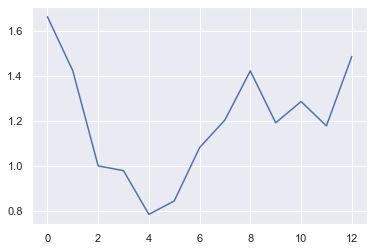

In [6]:
import seaborn as sns

sns.set(style="darkgrid")
sns.lineplot(data=scores)

In [ ]:
import optuna


def objective(trial: optuna.Trial) -> float:
    lag = trial.suggest_int("lag", 2, 30)
    forecaster = LGBMForecaster(lgb.LGBMRegressor(), lag=lag)

    scores: Sequence[float] = cross_validate(forecaster, splitter=splitter, y=df[["new_cases"]])
    return np.mean(scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

study.best_params
# Best found lag value with default LGBM params: 9

In [7]:
from nepal.graph import Connection, LocalConnection, GraphDB

conn: Connection = LocalConnection(
    database="neo4j",
    password="corona",
)

assert conn.is_up()

In [8]:
import optuna
import lightgbm as lgb
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

from nepal.ml.forecaster import LGBMForecaster
from nepal.ml.splitter import Splitter

from nepal.graph.gds import CountyEmbedding


embedding = CountyEmbedding()
fh = ForecastingHorizon(list(range(1, 15)))
cv = SlidingWindowSplitter(fh=fh, window_length=120, step_length=60)
splitter: Splitter = Splitter(cv)

# Create regressor with default parameters
forecaster = LGBMForecaster(lgb.LGBMRegressor(), lag=13)


def objective(trial: optuna.Trial) -> float:
    forecaster = LGBMForecaster(lgb.LGBMRegressor(), lag=13)

    X: pd.DataFrame = embedding.load_dataframe(
        connection=conn,
        embedding_dimension=trial.suggest_int("dim", 8, 512, log=True),
        weight2=trial.suggest_float("weight2", 0.0, 1.0),
        weight3=trial.suggest_float("weight3", 0.0, 1.0),
        weight4=trial.suggest_float("weight4", 0.0, 1.0),
        normalization=trial.suggest_float("normalization", -1.0, 1.0),
        property_ratio=trial.suggest_float("prop_ratio", 0.0, 1.0),
        self_influence=trial.suggest_float("self_influence", 0.0, 1.0),
    ).rename(index={"fips": "FIPS"})

    scores: Sequence[float] = cross_validate(
        forecaster, splitter=splitter, y=df[["new_cases"]], Xs=[X]
    )
    return np.mean(scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

study.best_params
# Best found values with default LGBM params and lag=13:
# {'dim': 13,
#  'weight2': 0.9095431576049532,
#  'weight3': 0.3804723961743889,
#  'weight4': 0.9975167117131349,
#  'normalization': -0.9871365897384008,
#  'prop_ratio': 0.12685783148389826,
#  'self_influence': 0.44962816623765073}

[I 2022-05-31 22:25:57,580] A new study created in memory with name: no-name-fab83e15-8fb9-4679-95c8-66995da820da


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:27:21,659] Trial 0 finished with value: 1.1614616008561958 and parameters: {'dim': 18, 'weight2': 0.9605090767692531, 'weight3': 0.9742550704407172, 'weight4': 0.5089544189402592, 'normalization': 0.3418570745185203, 'prop_ratio': 0.4981737561617142, 'self_influence': 0.8513722138411854}. Best is trial 0 with value: 1.1614616008561958.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:28:46,866] Trial 1 finished with value: 1.1629789749027537 and parameters: {'dim': 33, 'weight2': 0.46244147230145594, 'weight3': 0.8968138381124989, 'weight4': 0.8930463088735868, 'normalization': 0.06845670937754655, 'prop_ratio': 0.18610362570860484, 'self_influence': 0.3933267375871572}. Best is trial 0 with value: 1.1614616008561958.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:30:20,534] Trial 2 finished with value: 1.1641371084909564 and parameters: {'dim': 64, 'weight2': 0.16976549645578665, 'weight3': 0.7907948589200351, 'weight4': 0.04649675283420818, 'normalization': 0.8366394235785566, 'prop_ratio': 0.6472524025875208, 'self_influence': 0.8476021601522646}. Best is trial 0 with value: 1.1614616008561958.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:32:06,501] Trial 3 finished with value: 1.165037539427818 and parameters: {'dim': 69, 'weight2': 0.5918933474516418, 'weight3': 0.6962476351641363, 'weight4': 0.04501071500395226, 'normalization': 0.02482844744715762, 'prop_ratio': 0.6608364875141058, 'self_influence': 0.6187214814873438}. Best is trial 0 with value: 1.1614616008561958.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:33:24,521] Trial 4 finished with value: 1.1636567910166304 and parameters: {'dim': 10, 'weight2': 0.5589411618599324, 'weight3': 0.09451629525635497, 'weight4': 0.05753118628527809, 'normalization': -0.8487876028199897, 'prop_ratio': 0.6763862874356271, 'self_influence': 0.8013566501530858}. Best is trial 0 with value: 1.1614616008561958.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:34:55,423] Trial 5 finished with value: 1.1633542387604883 and parameters: {'dim': 39, 'weight2': 0.07158800290985623, 'weight3': 0.857875393265592, 'weight4': 0.3526790182042454, 'normalization': 0.5895476961425485, 'prop_ratio': 0.6988964704089019, 'self_influence': 0.3209251718739471}. Best is trial 0 with value: 1.1614616008561958.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:36:15,127] Trial 6 finished with value: 1.1625114619965513 and parameters: {'dim': 11, 'weight2': 0.10285672057931683, 'weight3': 0.31054520887696024, 'weight4': 0.7631342164397877, 'normalization': 0.5489099490166043, 'prop_ratio': 0.3850868431225153, 'self_influence': 0.6629164962022112}. Best is trial 0 with value: 1.1614616008561958.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:37:48,011] Trial 7 finished with value: 1.165471050713774 and parameters: {'dim': 42, 'weight2': 0.9900207578401866, 'weight3': 0.7838889770918986, 'weight4': 0.5512120817516677, 'normalization': -0.5255618311628716, 'prop_ratio': 0.8793760850029226, 'self_influence': 0.6670105103081356}. Best is trial 0 with value: 1.1614616008561958.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:41:27,951] Trial 8 finished with value: 1.1645484795801377 and parameters: {'dim': 355, 'weight2': 0.21394724342425042, 'weight3': 0.6770346762451284, 'weight4': 0.36368923450968693, 'normalization': 0.5795121822084244, 'prop_ratio': 0.05181282970114742, 'self_influence': 0.6659294713795809}. Best is trial 0 with value: 1.1614616008561958.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:43:19,546] Trial 9 finished with value: 1.1631336622549828 and parameters: {'dim': 111, 'weight2': 0.00809559179216568, 'weight3': 0.8247413017258771, 'weight4': 0.315736253054562, 'normalization': 0.6550867872365067, 'prop_ratio': 0.19406850717123114, 'self_influence': 0.22362985847260808}. Best is trial 0 with value: 1.1614616008561958.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:44:39,774] Trial 10 finished with value: 1.16469359863173 and parameters: {'dim': 18, 'weight2': 0.9577989582104844, 'weight3': 0.4922622904113955, 'weight4': 0.6186941104532702, 'normalization': -0.3140338176327876, 'prop_ratio': 0.4019892528340501, 'self_influence': 0.9634113892729802}. Best is trial 0 with value: 1.1614616008561958.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:45:58,088] Trial 11 finished with value: 1.1604021317651785 and parameters: {'dim': 8, 'weight2': 0.7135948644543276, 'weight3': 0.3024364736622952, 'weight4': 0.7550927797402021, 'normalization': 0.24198826102755272, 'prop_ratio': 0.4173647534103163, 'self_influence': 0.084762041414013}. Best is trial 11 with value: 1.1604021317651785.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:47:15,430] Trial 12 finished with value: 1.1612166984768104 and parameters: {'dim': 8, 'weight2': 0.8132598141340661, 'weight3': 0.2879747189459305, 'weight4': 0.9784778284394092, 'normalization': 0.24175064099358, 'prop_ratio': 0.4499231618180835, 'self_influence': 0.0032716357858427747}. Best is trial 11 with value: 1.1604021317651785.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:48:30,072] Trial 13 finished with value: 1.1617835268163967 and parameters: {'dim': 8, 'weight2': 0.7553287611303526, 'weight3': 0.2442997934999532, 'weight4': 0.9753322957893118, 'normalization': 0.2838756185462128, 'prop_ratio': 0.27359734587914475, 'self_influence': 0.01031037524512926}. Best is trial 11 with value: 1.1604021317651785.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:49:46,083] Trial 14 finished with value: 1.1632682549885704 and parameters: {'dim': 18, 'weight2': 0.8023890019585342, 'weight3': 0.41967445070552645, 'weight4': 0.7674061683584277, 'normalization': -0.23754138545339132, 'prop_ratio': 0.510247568520607, 'self_influence': 0.019909130292676464}. Best is trial 11 with value: 1.1604021317651785.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:52:12,238] Trial 15 finished with value: 1.166024601466707 and parameters: {'dim': 211, 'weight2': 0.7544087138232626, 'weight3': 0.006871325314368182, 'weight4': 0.7971424885409335, 'normalization': 0.21516507261623313, 'prop_ratio': 0.9985645300332302, 'self_influence': 0.18571973100792263}. Best is trial 11 with value: 1.1604021317651785.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:53:34,392] Trial 16 finished with value: 1.1632350165212417 and parameters: {'dim': 14, 'weight2': 0.3607201596552181, 'weight3': 0.20612435472930107, 'weight4': 0.9851896683869733, 'normalization': 0.9464096223696756, 'prop_ratio': 0.5049161077204967, 'self_influence': 0.1569640168005907}. Best is trial 11 with value: 1.1604021317651785.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:54:52,609] Trial 17 finished with value: 1.1624962620693589 and parameters: {'dim': 27, 'weight2': 0.6468509987717889, 'weight3': 0.3704171504769612, 'weight4': 0.6654308681061135, 'normalization': -0.1947376745614459, 'prop_ratio': 0.32924855798990743, 'self_influence': 0.09721725670231392}. Best is trial 11 with value: 1.1604021317651785.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:56:04,766] Trial 18 finished with value: 1.1613993623558676 and parameters: {'dim': 8, 'weight2': 0.8099911697072608, 'weight3': 0.5166670205971247, 'weight4': 0.8609146678456309, 'normalization': -0.46799810314764606, 'prop_ratio': 0.008818242288177403, 'self_influence': 0.3265380015907692}. Best is trial 11 with value: 1.1604021317651785.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:57:53,908] Trial 19 finished with value: 1.1652282123767281 and parameters: {'dim': 125, 'weight2': 0.4146364962826808, 'weight3': 0.14847577057064448, 'weight4': 0.6914863479935826, 'normalization': 0.3736547675003178, 'prop_ratio': 0.5516181927915846, 'self_influence': 0.4703537833884797}. Best is trial 11 with value: 1.1604021317651785.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 22:59:12,404] Trial 20 finished with value: 1.1647625085965256 and parameters: {'dim': 24, 'weight2': 0.6591825527151863, 'weight3': 0.5821927994253753, 'weight4': 0.8939311968798698, 'normalization': -0.07664401128731002, 'prop_ratio': 0.8012535888122297, 'self_influence': 0.0985647667630493}. Best is trial 11 with value: 1.1604021317651785.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:00:25,362] Trial 21 finished with value: 1.1615502719255544 and parameters: {'dim': 8, 'weight2': 0.8492465566861651, 'weight3': 0.5159923555829647, 'weight4': 0.8742679290895033, 'normalization': -0.5985891593191033, 'prop_ratio': 0.007032474441254251, 'self_influence': 0.27993855078478624}. Best is trial 11 with value: 1.1604021317651785.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:01:39,584] Trial 22 finished with value: 1.1606849088905167 and parameters: {'dim': 13, 'weight2': 0.8737010364860301, 'weight3': 0.3388497475680614, 'weight4': 0.9978284981685288, 'normalization': -0.9519384990325692, 'prop_ratio': 0.1148174031962844, 'self_influence': 0.3392196413675873}. Best is trial 11 with value: 1.1604021317651785.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:02:52,393] Trial 23 finished with value: 1.160906011121756 and parameters: {'dim': 13, 'weight2': 0.8926296239194083, 'weight3': 0.30768561656510013, 'weight4': 0.9891323690477183, 'normalization': -0.8733770354033383, 'prop_ratio': 0.14677844319519096, 'self_influence': 0.1071496264650898}. Best is trial 11 with value: 1.1604021317651785.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:04:06,818] Trial 24 finished with value: 1.1591163807156135 and parameters: {'dim': 13, 'weight2': 0.9095431576049532, 'weight3': 0.3804723961743889, 'weight4': 0.9975167117131349, 'normalization': -0.9871365897384008, 'prop_ratio': 0.12685783148389826, 'self_influence': 0.44962816623765073}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:05:23,780] Trial 25 finished with value: 1.1606301790884281 and parameters: {'dim': 14, 'weight2': 0.6988145973950404, 'weight3': 0.3908075761792773, 'weight4': 0.840878770340131, 'normalization': -0.9803394095455722, 'prop_ratio': 0.1206066273372568, 'self_influence': 0.49913580180282513}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:06:48,590] Trial 26 finished with value: 1.1652467196287712 and parameters: {'dim': 23, 'weight2': 0.7047161269881094, 'weight3': 0.42943545593399024, 'weight4': 0.8215505521193596, 'normalization': -0.7989572615896818, 'prop_ratio': 0.23924852543398767, 'self_influence': 0.53632529955446}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:08:07,696] Trial 27 finished with value: 1.1644266866351642 and parameters: {'dim': 17, 'weight2': 0.5492599676528565, 'weight3': 0.18411688543719956, 'weight4': 0.7105930665795598, 'normalization': -0.6283689186100734, 'prop_ratio': 0.314774966803689, 'self_influence': 0.43073412019848584}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:09:38,230] Trial 28 finished with value: 1.1622254289377745 and parameters: {'dim': 50, 'weight2': 0.6657639431216256, 'weight3': 0.39716851569830836, 'weight4': 0.6044655703572556, 'normalization': -0.7461582439045873, 'prop_ratio': 0.07299649035332917, 'self_influence': 0.4901783591516654}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:10:54,254] Trial 29 finished with value: 1.1606952698926856 and parameters: {'dim': 11, 'weight2': 0.7337796793444178, 'weight3': 0.6140679420888748, 'weight4': 0.5249433683745923, 'normalization': -0.9656184617229062, 'prop_ratio': 0.23616283224568735, 'self_influence': 0.5839943627537693}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:12:15,292] Trial 30 finished with value: 1.1611405864222732 and parameters: {'dim': 20, 'weight2': 0.9557658125350481, 'weight3': 0.07613466544000075, 'weight4': 0.45070659597086554, 'normalization': -0.43126970256801656, 'prop_ratio': 0.11356571440278383, 'self_influence': 0.7664144627334465}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:13:35,249] Trial 31 finished with value: 1.1608147143955767 and parameters: {'dim': 14, 'weight2': 0.8855550670339623, 'weight3': 0.36965177962041196, 'weight4': 0.9263662806869318, 'normalization': -0.9914275503905695, 'prop_ratio': 0.12202513664133689, 'self_influence': 0.36533700176057005}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:15:04,518] Trial 32 finished with value: 1.1608705659029648 and parameters: {'dim': 11, 'weight2': 0.8957819749649648, 'weight3': 0.4612205956993836, 'weight4': 0.9246931047401236, 'normalization': -0.7333615229267845, 'prop_ratio': 0.17361863853263515, 'self_influence': 0.421385377528699}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:16:34,170] Trial 33 finished with value: 1.1617673979131775 and parameters: {'dim': 33, 'weight2': 0.4972021848554936, 'weight3': 0.3385638496854787, 'weight4': 0.8336620825767403, 'normalization': -0.9657055272183476, 'prop_ratio': 0.08314695238954353, 'self_influence': 0.257537833456714}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:17:54,798] Trial 34 finished with value: 1.160607446912519 and parameters: {'dim': 16, 'weight2': 0.6108531897799585, 'weight3': 0.2613031685445455, 'weight4': 0.9173525181068017, 'normalization': -0.6662496689901636, 'prop_ratio': 0.19480233034479358, 'self_influence': 0.5171079356783352}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:19:30,838] Trial 35 finished with value: 1.1632922972311441 and parameters: {'dim': 28, 'weight2': 0.6256112569059918, 'weight3': 0.9752738508454899, 'weight4': 0.7237948943647216, 'normalization': 0.09610928389887508, 'prop_ratio': 0.31390908660290556, 'self_influence': 0.5731562019952195}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:20:52,135] Trial 36 finished with value: 1.1626091145730195 and parameters: {'dim': 15, 'weight2': 0.4264361589718003, 'weight3': 0.2746386434337079, 'weight4': 0.9221252033508127, 'normalization': -0.6056886406508778, 'prop_ratio': 0.5731081279515261, 'self_influence': 0.7333197691423218}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:22:08,898] Trial 37 finished with value: 1.161266836577776 and parameters: {'dim': 10, 'weight2': 0.5827048025702306, 'weight3': 0.24325488361159386, 'weight4': 0.1909411460318447, 'normalization': -0.7360302312953273, 'prop_ratio': 0.19929943251123727, 'self_influence': 0.5010904448989048}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:23:52,315] Trial 38 finished with value: 1.1668821181878601 and parameters: {'dim': 86, 'weight2': 0.31597174394936983, 'weight3': 0.15962708557240576, 'weight4': 0.7688239034084141, 'normalization': -0.35366788596302984, 'prop_ratio': 0.4117184305447141, 'self_influence': 0.881594527196419}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:25:09,493] Trial 39 finished with value: 1.164166519191657 and parameters: {'dim': 21, 'weight2': 0.5412756137938539, 'weight3': 0.551848664267285, 'weight4': 0.8419390425886459, 'normalization': 0.4373881277923901, 'prop_ratio': 0.35449800976225687, 'self_influence': 0.39163678822700543}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:26:38,916] Trial 40 finished with value: 1.1636581920198217 and parameters: {'dim': 51, 'weight2': 0.693127383312202, 'weight3': 0.11290304070708651, 'weight4': 0.9155649646525342, 'normalization': -0.8552449826962036, 'prop_ratio': 0.265659705519838, 'self_influence': 0.6167157226289408}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:27:54,515] Trial 41 finished with value: 1.161619349801226 and parameters: {'dim': 10, 'weight2': 0.7770536683052972, 'weight3': 0.3239906389891056, 'weight4': 0.94533044811171, 'normalization': -0.9011495105930248, 'prop_ratio': 0.05261649658756484, 'self_influence': 0.33909545703381216}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:29:10,553] Trial 42 finished with value: 1.1606872253852594 and parameters: {'dim': 11, 'weight2': 0.9224579844293141, 'weight3': 0.4603826671177729, 'weight4': 0.8916090116487666, 'normalization': -0.6613154797325296, 'prop_ratio': 0.15359636134254856, 'self_influence': 0.45644712640867807}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:30:34,241] Trial 43 finished with value: 1.1608785955973955 and parameters: {'dim': 13, 'weight2': 0.9992966044510054, 'weight3': 0.2416897864212508, 'weight4': 0.7874915110389267, 'normalization': -0.9969401290914989, 'prop_ratio': 0.2229170055040225, 'self_influence': 0.5377038827327761}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:31:58,720] Trial 44 finished with value: 1.1606588671186715 and parameters: {'dim': 34, 'weight2': 0.8498982035895547, 'weight3': 0.3744475143197752, 'weight4': 0.9943425200157268, 'normalization': -0.8258405288771304, 'prop_ratio': 0.10533587973199549, 'self_influence': 0.27851635446244977}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:33:22,757] Trial 45 finished with value: 1.160951105501621 and parameters: {'dim': 35, 'weight2': 0.8317106546676858, 'weight3': 0.3863326907205045, 'weight4': 0.8583519091099823, 'normalization': -0.8036877273923881, 'prop_ratio': 0.03746502090345455, 'self_influence': 0.29457374991220026}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:34:45,762] Trial 46 finished with value: 1.163033992576763 and parameters: {'dim': 17, 'weight2': 0.610747434006724, 'weight3': 0.4590379706642499, 'weight4': 0.9530553591484084, 'normalization': 0.13715806579576462, 'prop_ratio': 0.27966990788574914, 'self_influence': 0.2241790758586901}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:36:16,452] Trial 47 finished with value: 1.1651146336481215 and parameters: {'dim': 43, 'weight2': 0.7007924210929495, 'weight3': 0.2752634442260913, 'weight4': 0.743456672567526, 'normalization': -0.02545620231156908, 'prop_ratio': 0.09436444913864983, 'self_influence': 0.7011195509852306}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:37:44,414] Trial 48 finished with value: 1.163075606158799 and parameters: {'dim': 30, 'weight2': 0.7302740652660662, 'weight3': 0.6720658332706047, 'weight4': 0.6333044486250271, 'normalization': -0.6975958773777546, 'prop_ratio': 0.45681172519967594, 'self_influence': 0.1613087619009701}. Best is trial 24 with value: 1.1591163807156135.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-05-31 23:39:33,260] Trial 49 finished with value: 1.1634882254733259 and parameters: {'dim': 64, 'weight2': 0.7695046856008602, 'weight3': 0.2099954453504308, 'weight4': 0.8002681299946166, 'normalization': 0.7951999912279567, 'prop_ratio': 0.17432576125399624, 'self_influence': 0.055778975009438396}. Best is trial 24 with value: 1.1591163807156135.


{'dim': 13,
 'weight2': 0.9095431576049532,
 'weight3': 0.3804723961743889,
 'weight4': 0.9975167117131349,
 'normalization': -0.9871365897384008,
 'prop_ratio': 0.12685783148389826,
 'self_influence': 0.44962816623765073}

In [13]:
# Evaluate found parameters

fh = ForecastingHorizon(list(range(1, 15)))
cv = SlidingWindowSplitter(fh=fh, window_length=120, step_length=60)
splitter: Splitter = Splitter(cv)

# Create regressor with default parameters
forecaster = LGBMForecaster(lgb.LGBMRegressor(), lag=13)
embedding = CountyEmbedding()

X: pd.DataFrame = embedding.load_dataframe(
    connection=conn,
    embedding_dimension=16,
    weight2=0.9,
    weight3=0.4,
    weight4=1.0,
    normalization=-1.0,
    property_ratio=0.15,
    self_influence=0.45,
)

scores: Sequence[float] = cross_validate(
    forecaster, splitter=splitter, y=df[["new_cases"]], Xs=[X]
)

print(np.mean(scores))

Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

1.1615128487786013
